# Setup some tooling for running simulations
I copied parts of this from [another notebook](../eval/igraph-runner-demo.ipynb). At some point, we probably want to extract the relevant bits into a shared python script or module.

In [1]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = seed
    with subprocess.Popen(
        ["dune", "exec", "graphml_runner"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout

# Define network

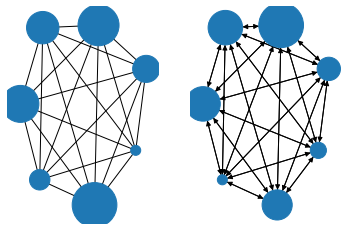

In [3]:
def net(n=7, delta=1):
    N = range(1, n + 1)
    G = nx.complete_graph(N)
    G.graph["dissemination"] = "simple"
    nx.set_node_attributes(G, {m: m for m in N}, "compute")
    nx.set_edge_attributes(G, f"uniform {0.5*delta} {1.5*delta}", "delay")
    return G


plt.subplot(1, 2, 1)
n = net()
lyt = draw(n, size="compute")
r = sim(n, activations=32, protocol="tailstorm 8 discount")
plt.subplot(1, 2, 2)
draw(r, size="reward", layout=lyt)

# Run simulations

In [4]:
ks = [2, 4, 8, 16]
protocols = ["nakamoto", "ethereum"]
protocols += [f"tailstorm {k} {r}" for k in ks for r in ["constant", "discount"]]
protocols += [f"bk {k}" for k in ks]
iterations = range(10)
activations = [1000]
deltas = [1]
activation_delays = [1, 2, 4, 8]
input_df = pd.DataFrame(
    itertools.product(iterations, protocols, deltas, activation_delays, activations),
    columns=["iteration", "protocol", "delta", "activation_delay", "activations"],
)
input_df

,iteration,protocol,delta,activation_delay,activations
0,0,nakamoto,1,1,1000
1,0,nakamoto,1,2,1000
2,0,nakamoto,1,4,1000
3,0,nakamoto,1,8,1000
4,0,ethereum,1,1,1000
...,...,...,...,...,...
555,9,bk 8,1,8,1000
556,9,bk 16,1,1,1000
557,9,bk 16,1,2,1000
558,9,bk 16,1,4,1000


In [5]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, use_memory_fs=False)


def per_row(r):
    r["G"] = sim(
        net(delta=r.delta),
        activation_delay=r.activation_delay,
        protocol=r.protocol,
        activations=r.activations,
        seed=r.iteration,
    )
    return r


run_df = input_df.parallel_apply(per_row, axis=1, result_type="expand")

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
acc = []
for i, r in run_df.iterrows():
    p = r.G.graph["head_progress"]
    n = pd.DataFrame.from_dict(r.G.nodes, orient="index")
    n["relative_compute"] = n.compute / sum(n.compute)
    n["efficiency"] = n.reward / p / n.relative_compute
    for k in r.keys():
        if k not in ["G", "activations"]:
            n[k] = r[k]
    acc.append(n)
node_df = pd.concat(acc)
node_df

,activations,reward,compute,relative_compute,efficiency,iteration,protocol,delta,activation_delay
1,43.0,14.0,1.0,0.035714,0.652246,0,nakamoto,1,1
2,68.0,25.0,2.0,0.071429,0.582363,0,nakamoto,1,1
3,108.0,55.0,3.0,0.107143,0.854132,0,nakamoto,1,1
4,133.0,75.0,4.0,0.142857,0.873544,0,nakamoto,1,1
5,164.0,89.0,5.0,0.178571,0.829285,0,nakamoto,1,1
...,...,...,...,...,...,...,...,...,...
3,104.0,103.0,3.0,0.107143,0.983965,9,bk 16,1,8
4,169.0,163.0,4.0,0.142857,1.167861,9,bk 16,1,8
5,171.0,166.0,5.0,0.178571,0.951484,9,bk 16,1,8
6,204.0,201.0,6.0,0.214286,0.960082,9,bk 16,1,8


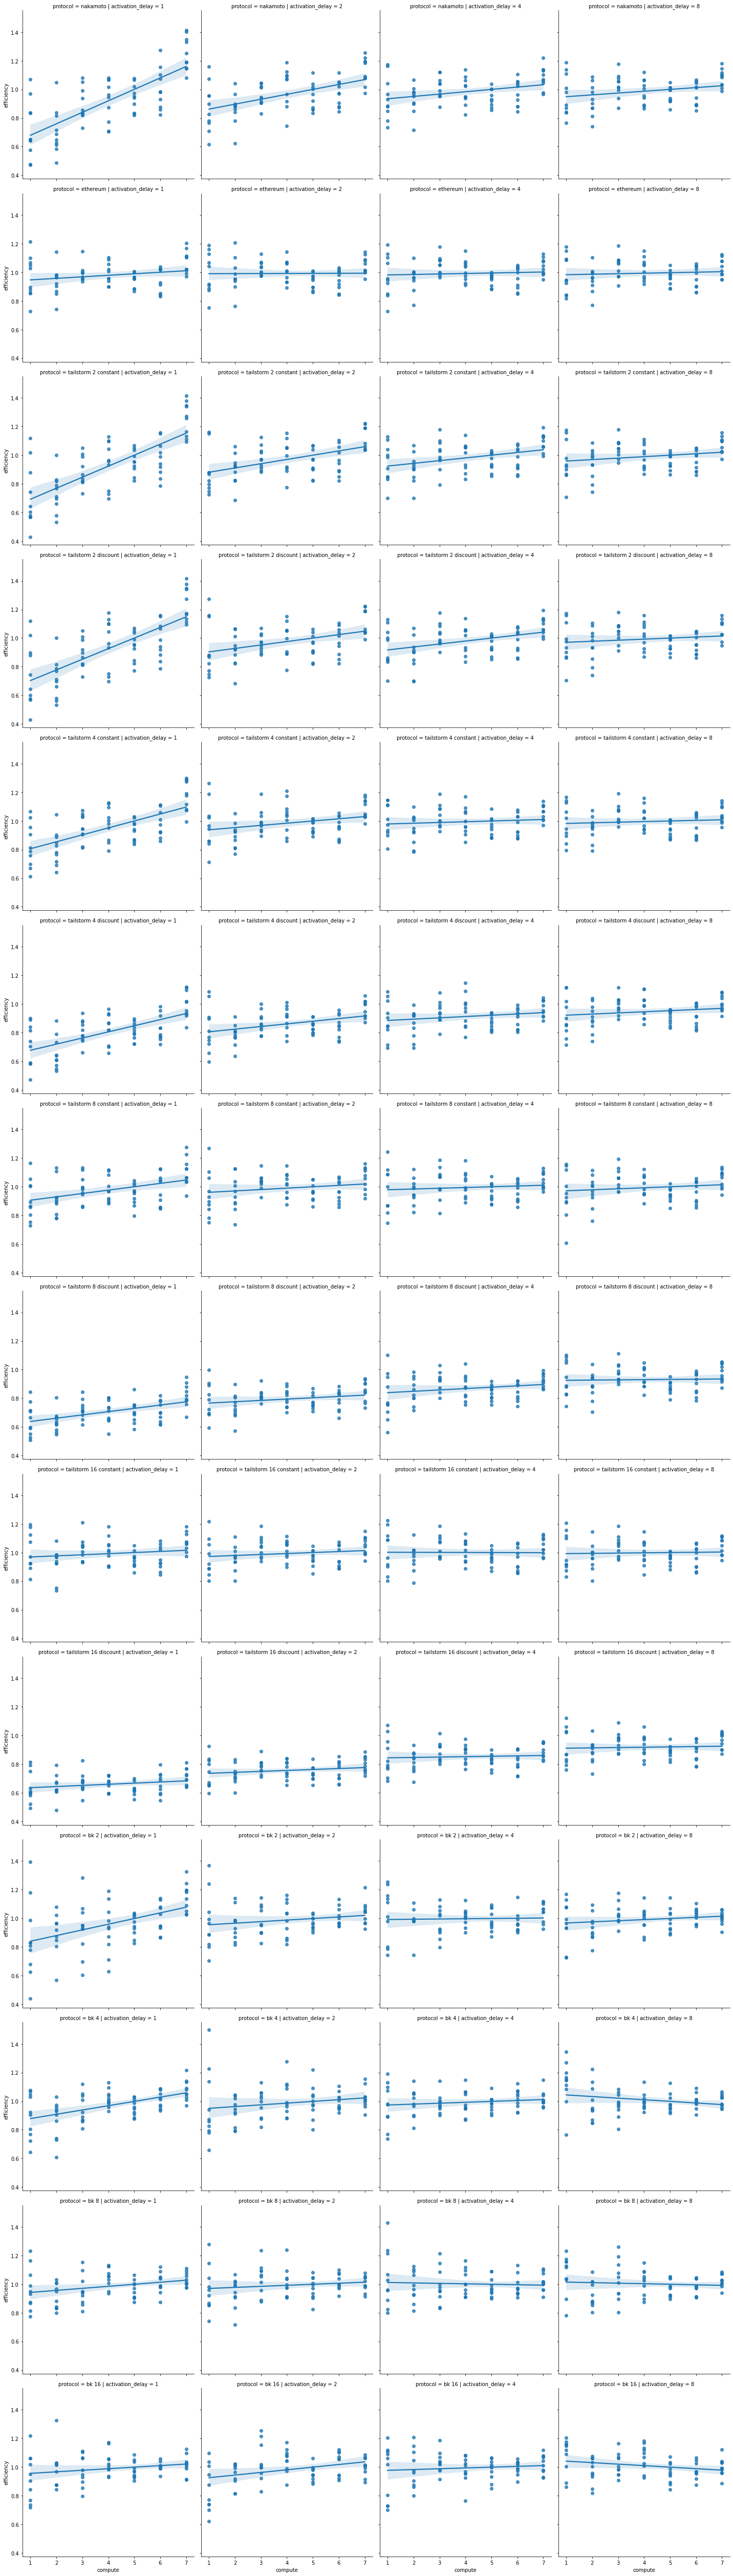

In [7]:
sns.lmplot(
    data=node_df, x="compute", y="efficiency", col="activation_delay", row="protocol"
)